## 4. KR-FinBERT-SentimentClassification

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.5 MB/s eta 0:00:00


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')  # 경고메시지 숨기기

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn

from tensorflow import nn
from tensorflow import function, GradientTape, sqrt, abs, reduce_mean, ones_like, zeros_like, convert_to_tensor,float32
from tensorflow import data as tfdata
from tensorflow import config as tfconfig
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import Image
from tqdm import tqdm, trange

In [ ]:
data = pd.read_csv("./concat_total.csv")
data

,일자,제목,종목명,시가총액비율
0,20230201,삼성전자 ‘수평 호칭’ 경영 임원진 확대,삼성전자,0.542072
1,20230201,감산을 감산이라고 부르지 못하는 삼성전자,삼성전자,0.542072
2,20230201,"""삼성전자 사실상 감산 돌입"" 골드만삭스는 되레 목표가 올렸다",삼성전자,0.542072
3,20230201,"S&P ""삼성전자, 최소 상반기까지 경영환경 어려워""",삼성전자,0.542072
4,20230201,"​경계현 삼성전자 사장, ""TSMC 성능‧수율 따라가야 한다""",삼성전자,0.542072
...,...,...,...,...
5528,20221108,"애플 공급망 뚫은 자화전자, 삼성 갤S23에도 OIS 납품",자화전자,0.000562
5529,20221109,[여의도 주식왕 2부] '저스템 vs 지투파워 vs 해성디에스' 여의도를 달굴 종목은?,해성디에스,0.000953
5530,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화",LS ELECTRIC,0.002529
5531,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화 나서",LS ELECTRIC,0.002529


In [ ]:
texts = list(data['제목'])
texts[:4]

['삼성전자 ‘수평 호칭’ 경영 임원진 확대',
 '감산을 감산이라고 부르지 못하는 삼성전자',
 '"삼성전자 사실상 감산 돌입" 골드만삭스는 되레 목표가 올렸다',
 'S&P "삼성전자, 최소 상반기까지 경영환경 어려워"']

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC").to(device)

In [ ]:
tokenizer.tokenize(texts[0])

['삼성전자', '‘', '수', '##평', '호', '##칭', '’', '경영', '임원', '##진', '확대']

In [ ]:
outputs_list = []
for text in tqdm(texts) :
    inputs = tokenizer(text, return_tensors='pt').to(device)
    output = model(**inputs)
    output = output.logits.tolist()[0]
    outputs_list.append(output)

100%|██████████| 5533/5533 [01:33<00:00, 58.99it/s]


In [ ]:
outputs = torch.tensor(outputs_list)
outputs

tensor([[-2.0948,  0.6534,  1.6721],
        [ 0.4985,  3.8491, -4.1870],
        [ 0.1261, -3.3917,  3.5876],
        ...,
        [-3.9068, -2.3270,  6.4261],
        [-3.8949, -2.3371,  6.3984],
        [-1.4485, -0.1096,  2.1618]])

In [ ]:
#  !pip install tensorflow==1.15

predictions = torch.nn.functional.softmax(outputs, dim=-1)
predictions

tensor([[1.6706e-02, 2.6084e-01, 7.2245e-01],
        [3.3864e-02, 9.6582e-01, 3.1251e-04],
        [3.0400e-02, 9.0182e-04, 9.6870e-01],
        ...,
        [3.2539e-05, 1.5795e-04, 9.9981e-01],
        [3.3852e-05, 1.6075e-04, 9.9981e-01],
        [2.3928e-02, 9.1277e-02, 8.8479e-01]])

In [ ]:
df_sc = pd.DataFrame(predictions.detach().numpy())
df_sc.columns = ['부정','중립','긍정']
df_sc

,부정,중립,긍정
0,0.016706,0.260844,0.722450
1,0.033864,0.965823,0.000313
2,0.030400,0.000902,0.968698
3,0.991684,0.007893,0.000422
4,0.148762,0.843686,0.007552
...,...,...,...
5528,0.000034,0.000085,0.999881
5529,0.000033,0.999924,0.000043
5530,0.000033,0.000158,0.999810
5531,0.000034,0.000161,0.999805


In [ ]:
data = pd.concat([data, df_sc], axis=1)
data

,일자,제목,종목명,시가총액비율,부정,중립,긍정
0,20230201,삼성전자 ‘수평 호칭’ 경영 임원진 확대,삼성전자,0.542072,0.016706,0.260844,0.722450
1,20230201,감산을 감산이라고 부르지 못하는 삼성전자,삼성전자,0.542072,0.033864,0.965823,0.000313
2,20230201,"""삼성전자 사실상 감산 돌입"" 골드만삭스는 되레 목표가 올렸다",삼성전자,0.542072,0.030400,0.000902,0.968698
3,20230201,"S&P ""삼성전자, 최소 상반기까지 경영환경 어려워""",삼성전자,0.542072,0.991684,0.007893,0.000422
4,20230201,"​경계현 삼성전자 사장, ""TSMC 성능‧수율 따라가야 한다""",삼성전자,0.542072,0.148762,0.843686,0.007552
...,...,...,...,...,...,...,...
5528,20221108,"애플 공급망 뚫은 자화전자, 삼성 갤S23에도 OIS 납품",자화전자,0.000562,0.000034,0.000085,0.999881
5529,20221109,[여의도 주식왕 2부] '저스템 vs 지투파워 vs 해성디에스' 여의도를 달굴 종목은?,해성디에스,0.000953,0.000033,0.999924,0.000043
5530,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화",LS ELECTRIC,0.002529,0.000033,0.000158,0.999810
5531,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화 나서",LS ELECTRIC,0.002529,0.000034,0.000161,0.999805


In [ ]:
data.to_csv('./sentimental_analysis.csv', index=False)

## 5. 감정수치/반응도

In [ ]:
df_score = data.copy()

In [ ]:
# 감성수치/반응도 산출

df_score['감성수치'] = np.where(df_score['부정'] >= df_score['긍정'], -df_score['부정'], df_score['긍정'])
df_score['반응도'] = np.where(df_score['부정'] >= df_score['긍정'], df_score['부정'], df_score['긍정'])
df_score

,일자,제목,종목명,시가총액비율,부정,중립,긍정,감성수치,반응도
0,20230201,삼성전자 ‘수평 호칭’ 경영 임원진 확대,삼성전자,0.542072,0.016706,0.260844,0.722450,0.722450,0.722450
1,20230201,감산을 감산이라고 부르지 못하는 삼성전자,삼성전자,0.542072,0.033864,0.965823,0.000313,-0.033864,0.033864
2,20230201,"""삼성전자 사실상 감산 돌입"" 골드만삭스는 되레 목표가 올렸다",삼성전자,0.542072,0.030400,0.000902,0.968698,0.968698,0.968698
3,20230201,"S&P ""삼성전자, 최소 상반기까지 경영환경 어려워""",삼성전자,0.542072,0.991684,0.007893,0.000422,-0.991684,0.991684
4,20230201,"​경계현 삼성전자 사장, ""TSMC 성능‧수율 따라가야 한다""",삼성전자,0.542072,0.148762,0.843686,0.007552,-0.148762,0.148762
...,...,...,...,...,...,...,...,...,...
5528,20221108,"애플 공급망 뚫은 자화전자, 삼성 갤S23에도 OIS 납품",자화전자,0.000562,0.000034,0.000085,0.999881,0.999881,0.999881
5529,20221109,[여의도 주식왕 2부] '저스템 vs 지투파워 vs 해성디에스' 여의도를 달굴 종목은?,해성디에스,0.000953,0.000033,0.999924,0.000043,0.000043,0.000043
5530,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화",LS ELECTRIC,0.002529,0.000033,0.000158,0.999810,0.999810,0.999810
5531,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화 나서",LS ELECTRIC,0.002529,0.000034,0.000161,0.999805,0.999805,0.999805


In [ ]:
# 감성수치/반응도에 시가총액비율 곱하기

df_score['감성수치w'] = df_score['감성수치'] * df_score['시가총액비율']
df_score['반응도w'] = df_score['반응도'] * df_score['시가총액비율']
df_score

,일자,제목,종목명,시가총액비율,부정,중립,긍정,감성수치,반응도,감성수치w,반응도w
0,20230201,삼성전자 ‘수평 호칭’ 경영 임원진 확대,삼성전자,0.542072,0.016706,0.260844,0.722450,0.722450,0.722450,3.916200e-01,3.916200e-01
1,20230201,감산을 감산이라고 부르지 못하는 삼성전자,삼성전자,0.542072,0.033864,0.965823,0.000313,-0.033864,0.033864,-1.835690e-02,1.835690e-02
2,20230201,"""삼성전자 사실상 감산 돌입"" 골드만삭스는 되레 목표가 올렸다",삼성전자,0.542072,0.030400,0.000902,0.968698,0.968698,0.968698,5.251045e-01,5.251045e-01
3,20230201,"S&P ""삼성전자, 최소 상반기까지 경영환경 어려워""",삼성전자,0.542072,0.991684,0.007893,0.000422,-0.991684,0.991684,-5.375647e-01,5.375647e-01
4,20230201,"​경계현 삼성전자 사장, ""TSMC 성능‧수율 따라가야 한다""",삼성전자,0.542072,0.148762,0.843686,0.007552,-0.148762,0.148762,-8.063977e-02,8.063977e-02
...,...,...,...,...,...,...,...,...,...,...,...
5528,20221108,"애플 공급망 뚫은 자화전자, 삼성 갤S23에도 OIS 납품",자화전자,0.000562,0.000034,0.000085,0.999881,0.999881,0.999881,5.622092e-04,5.622092e-04
5529,20221109,[여의도 주식왕 2부] '저스템 vs 지투파워 vs 해성디에스' 여의도를 달굴 종목은?,해성디에스,0.000953,0.000033,0.999924,0.000043,0.000043,0.000043,4.123693e-08,4.123693e-08
5530,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화",LS ELECTRIC,0.002529,0.000033,0.000158,0.999810,0.999810,0.999810,2.528986e-03,2.528986e-03
5531,20221106,"LS ELECTRIC, 태국과 스마트팩토리 사업 협력 강화 나서",LS ELECTRIC,0.002529,0.000034,0.000161,0.999805,0.999805,0.999805,2.528976e-03,2.528976e-03


In [ ]:
# 일자 별 분류

df_group = df_score.groupby(['일자','종목명'])[['감성수치w','반응도w']].mean()
df_group = pd.DataFrame(df_group)
df_group

감성수치w          반응도w
일자       종목명                               
20221101 LG이노텍   1.018543e-02  1.018543e-02
         LG전자    1.654161e-02  1.738723e-02
         SK하이닉스  9.129971e-02  9.129971e-02
         경동나비엔   4.102646e-06  4.102646e-06
         대한전선    3.194636e-03  3.194636e-03
...                       ...           ...
20230201 삼성SDI   7.273688e-02  7.273688e-02
         삼성전자    6.317144e-02  3.267129e-01
         신도리코    1.685078e-04  1.685078e-04
         이수페타시스  2.870103e-08  6.988925e-08
         현대일렉트릭  2.094468e-03  2.094468e-03

[654 rows x 2 columns]

In [ ]:
# 일자별 가중 감성수치/반응도의 합

df_sc = df_group.groupby('일자')[['감성수치w','반응도w']].sum()
df_sc

,감성수치w,반응도w
일자,,
20221101,0.241918,0.296423
20221102,0.188467,0.274503
20221103,0.183705,0.302999
20221104,0.255621,0.352920
20221105,0.020352,0.020352
...,...,...
20230128,0.347506,0.377051
20230129,0.122854,0.248831
20230130,0.369315,0.720850


In [ ]:
df_sc = df_sc.reset_index()
df_sc.columns = [['일자','감성수치','반응도']]
df_sc

,일자,감성수치,반응도
0,20221101,0.241918,0.296423
1,20221102,0.188467,0.274503
2,20221103,0.183705,0.302999
3,20221104,0.255621,0.352920
4,20221105,0.020352,0.020352
...,...,...,...
88,20230128,0.347506,0.377051
89,20230129,0.122854,0.248831
90,20230130,0.369315,0.720850
91,20230131,0.019369,0.675034


In [ ]:
df_sc.to_csv('sentimental_score.csv', index=False)

## 6. 시각화

In [ ]:
data_sc = pd.read_csv('sentimental_score.csv')
data_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      93 non-null     int64  
 1   감성수치    93 non-null     float64
 2   반응도     93 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.3 KB


In [ ]:
# datetime으로 변환

data_sc['일자'] = pd.to_datetime(data_sc['일자'].astype(str), format='%Y%m%d')
data_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      93 non-null     datetime64[ns]
 1   감성수치    93 non-null     float64       
 2   반응도     93 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.3 KB


In [ ]:
# 이동평균 추가

s_ma5 = data_sc['감성수치'].rolling(window=5).mean()
data_sc.insert(len(data_sc.columns), "S_MA5", s_ma5)
r_ma5 = data_sc['반응도'].rolling(window=5).mean()
data_sc.insert(len(data_sc.columns), "R_MA5", r_ma5)
data_sc

,일자,감성수치,반응도,S_MA5,R_MA5
0,2022-11-01,0.241918,0.296423,NaN,NaN
1,2022-11-02,0.188467,0.274503,NaN,NaN
2,2022-11-03,0.183705,0.302999,NaN,NaN
3,2022-11-04,0.255621,0.352920,NaN,NaN
4,2022-11-05,0.020352,0.020352,0.178012,0.249440
...,...,...,...,...,...
88,2023-01-28,0.347506,0.377051,0.341174,0.510309
89,2023-01-29,0.122854,0.248831,0.302529,0.454977
90,2023-01-30,0.369315,0.720850,0.315824,0.501973
91,2023-01-31,0.019369,0.675034,0.209161,0.514132


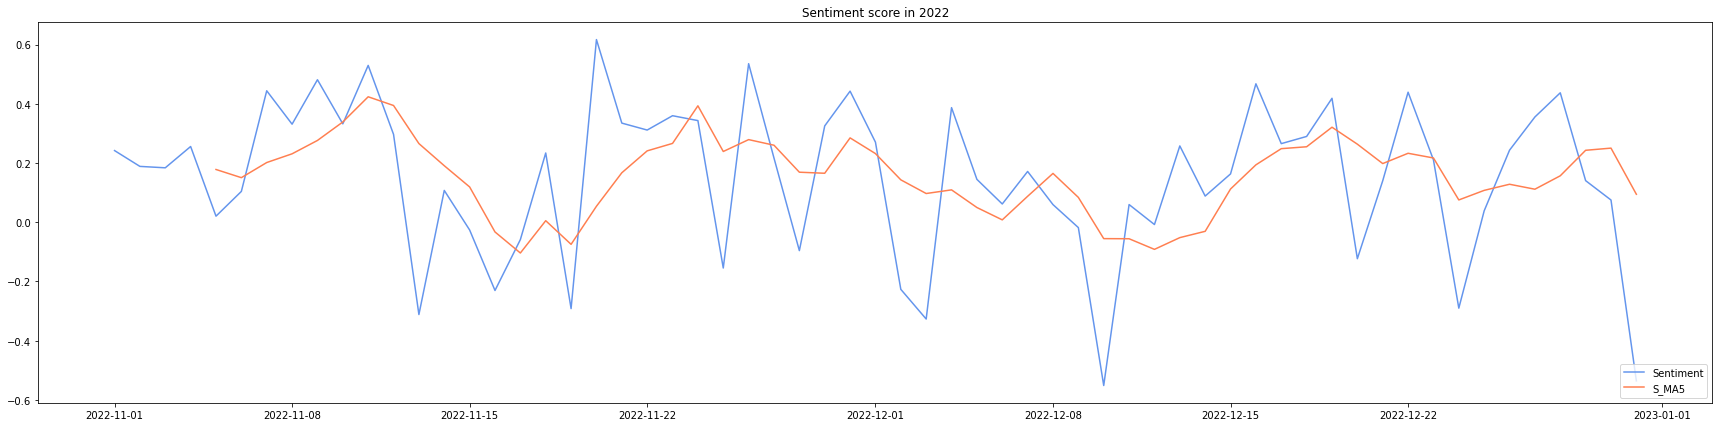

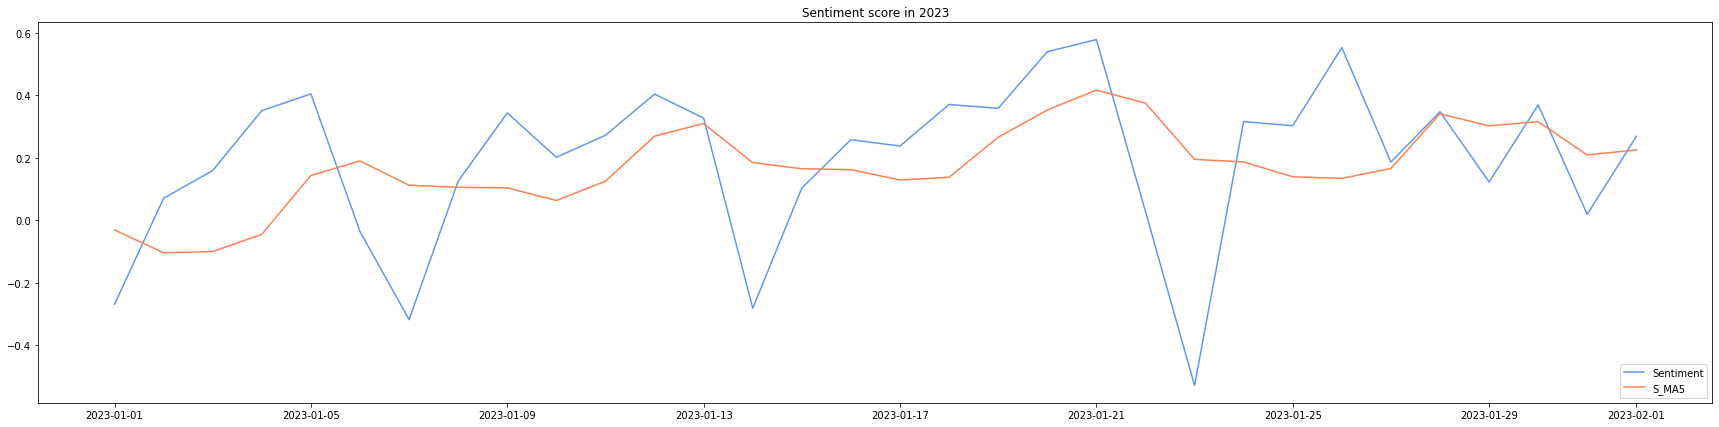

In [ ]:
# 감성수치 시각화

target_y = [2022, 2023]

for y in target_y :
    data_y = data_sc.query('일자.dt.year=='+str(y))
    
    plt.figure(figsize=(30,7))
    plt.title('Sentiment score in '+str(y))
    plt.plot(data_y['일자'], data_y['감성수치'], label='Sentiment', c='cornflowerblue')
    plt.plot(data_y['일자'], data_y['S_MA5'], label='S_MA5', c='coral')
    plt.legend(loc='lower right')
    plt.show()

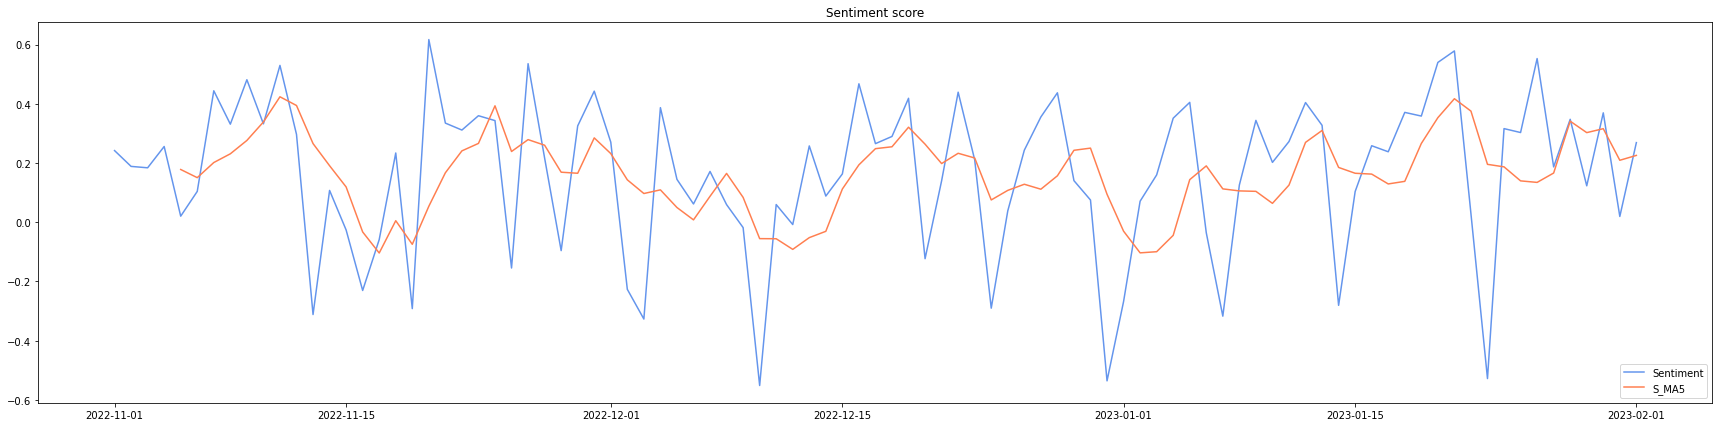

In [ ]:
data_y = data_sc

plt.figure(figsize=(30,7))
plt.title('Sentiment score')
plt.plot(data_y['일자'], data_y['감성수치'], label='Sentiment', c='cornflowerblue')
plt.plot(data_y['일자'], data_y['S_MA5'], label='S_MA5', c='coral')
plt.legend(loc='lower right')
plt.show()

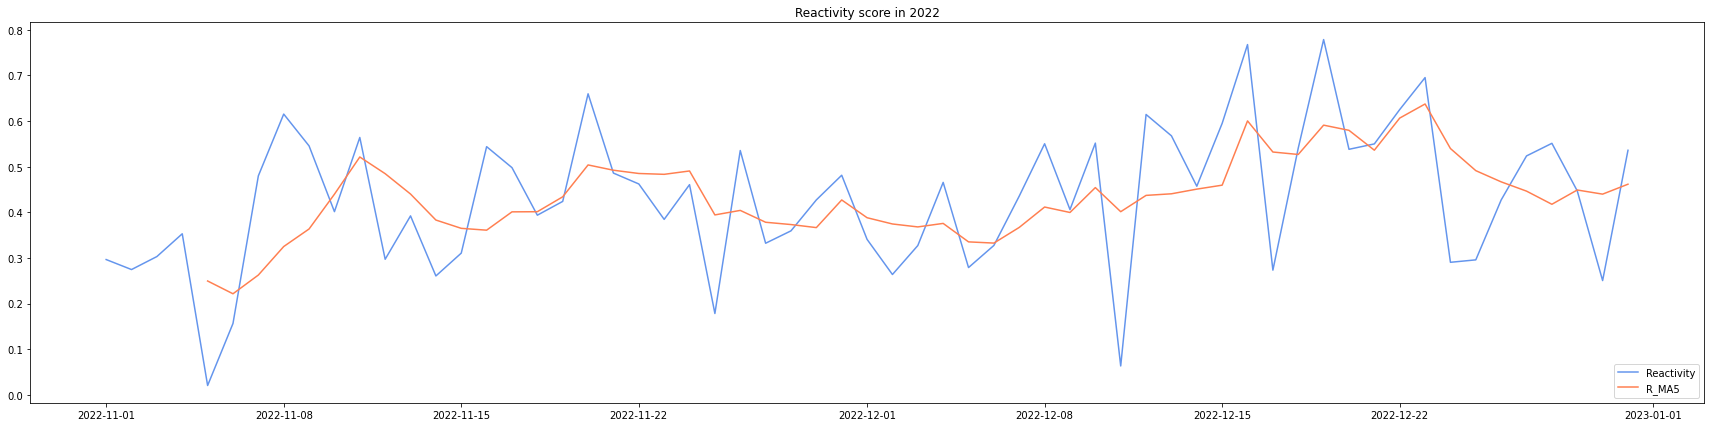

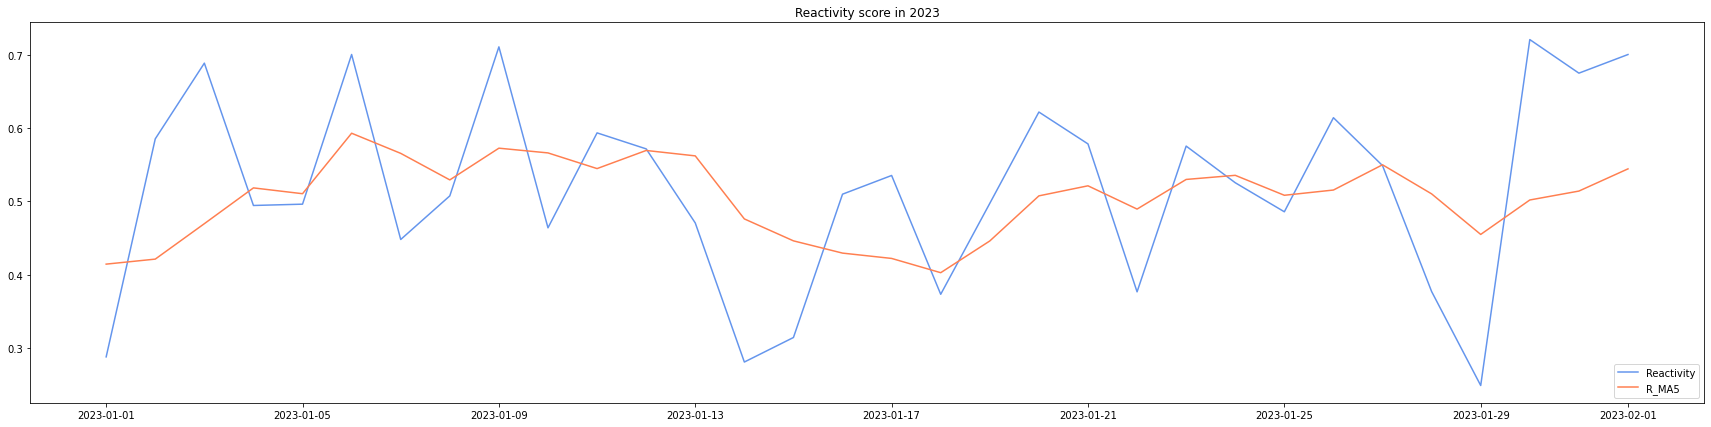

In [ ]:
# 반응도 시각화

for y in target_y :
    data_y = data_sc.query('일자.dt.year=='+str(y))
    
    plt.figure(figsize=(30,7))
    plt.title('Reactivity score in '+str(y))
    plt.plot(data_y['일자'], data_y['반응도'], label='Reactivity', c='cornflowerblue')
    plt.plot(data_y['일자'], data_y['R_MA5'], label='R_MA5', c='coral')
    plt.legend(loc='lower right')
    plt.show()

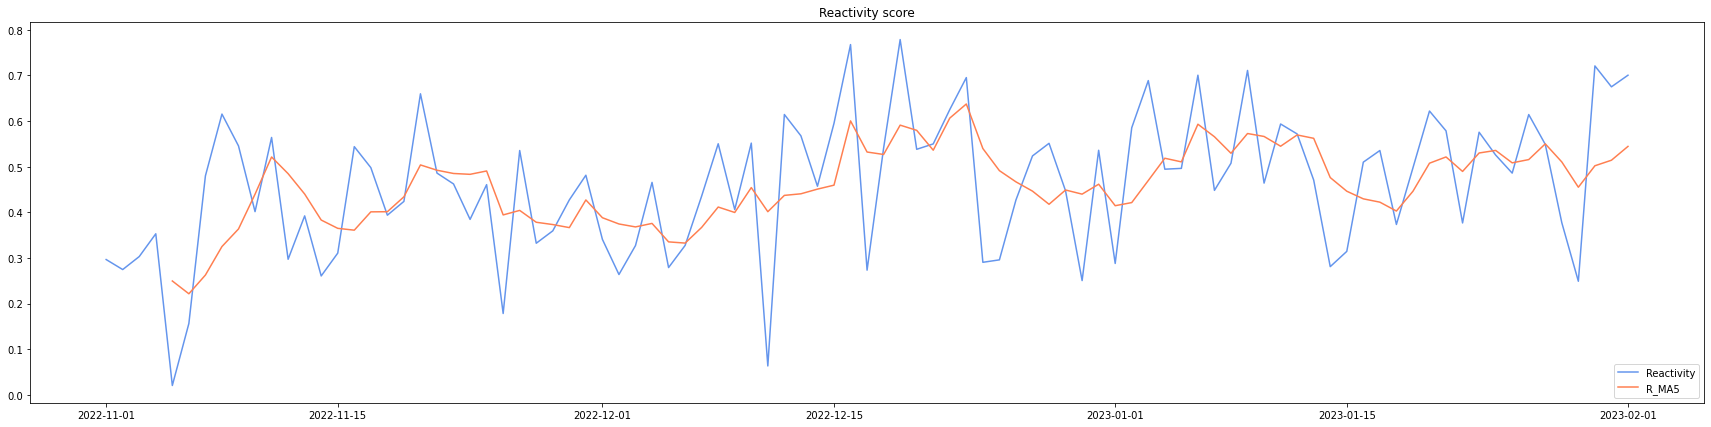

In [ ]:
data_y = data_sc

plt.figure(figsize=(30,7))
plt.title('Reactivity score')
plt.plot(data_y['일자'], data_y['반응도'], label='Reactivity', c='cornflowerblue')
plt.plot(data_y['일자'], data_y['R_MA5'], label='R_MA5', c='coral')
plt.legend(loc='lower right')
plt.show()

## Time-series Generative Adversarial Networks
- 감성분석으로 얻은 감성수치 데이터와 반응도 데이터 중 감성수치 데이터만을 사용
- 감성수치 데이터만으로 학습하는데 한계가 있어 부족한 데이터를 확장 시켰다.
- TimeGAN 모형으로 시계열 데이터를 확장 시켰다.
- 참고 문헌 : Yoon, Jinsung, Daniel Jarrett, and Mihaela Van der Schaar. "Time-series generative adversarial networks." Advances in neural information processing systems 32 (2019).


In [ ]:
elect = pd.read_csv('sutja_data_kospi.csv', encoding='cp949')
sc = pd.read_csv('sentimental_score.csv')


In [ ]:
elect.sort_values('일자', inplace=True)
elect.reset_index(drop=True, inplace = True)
elect['일자'] = pd.to_datetime(elect['일자'])
elect

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장시가총액
0,2022-11-01,23978.84,556.02,2.37,23556.21,23978.86,23470.57,169789.0,2750147.0,715019009.0
1,2022-11-02,23880.71,-98.13,-0.41,23876.64,24094.57,23753.32,76322.0,2324599.0,712408805.0
2,2022-11-03,23935.48,54.77,0.23,23446.60,24125.38,23446.60,83561.0,2417664.0,714409278.0
3,2022-11-04,24088.81,153.33,0.64,23915.53,24088.81,23737.97,97114.0,2301589.0,718991197.0
4,2022-11-07,24313.29,224.48,0.93,24213.62,24351.54,24149.51,55049.0,1936325.0,725962706.0
...,...,...,...,...,...,...,...,...,...,...
59,2023-01-26,24651.69,492.52,2.04,24296.07,24664.58,24067.50,89590.0,2282400.0,738388912.0
60,2023-01-27,24752.03,100.34,0.41,24738.84,24952.62,24598.42,61443.0,2499620.0,741693974.0
61,2023-01-30,24462.16,-289.87,-1.17,24734.78,24833.10,24304.91,68105.0,3259927.0,732845523.0
62,2023-01-31,24001.69,-460.47,-1.88,24442.36,24502.18,23982.18,84229.0,3643011.0,718086695.0


In [ ]:
sc['일자']= sc['일자'].astype('str')

In [ ]:
sc['일자'] = pd.to_datetime(sc['일자'])
sc

,일자,감성수치,반응도
0,2022-11-01,0.241918,0.296423
1,2022-11-02,0.188467,0.274503
2,2022-11-03,0.183705,0.302999
3,2022-11-04,0.255621,0.352920
4,2022-11-05,0.020352,0.020352
...,...,...,...
88,2023-01-28,0.347506,0.377051
89,2023-01-29,0.122854,0.248831
90,2023-01-30,0.369315,0.720850
91,2023-01-31,0.019369,0.675034


In [ ]:
df = pd.merge(elect, sc, on = ['일자'], how = 'left')
df.dropna(inplace=True)
df.drop(['대비', '등락률', '거래대금', '상장시가총액', '반응도'], axis=1, inplace=True)
df.rename(columns={'일자':'date', '종가':'close', '시가': 'open', '고가': 'high', '저가':'low', '거래량': 'volume', '감성수치': 'sc'}, inplace=True)
df = df.set_index('date').sort_index()
df

,close,open,high,low,volume,sc
date,,,,,,
2022-11-01,23978.84,23556.21,23978.86,23470.57,169789.0,0.241918
2022-11-02,23880.71,23876.64,24094.57,23753.32,76322.0,0.188467
2022-11-03,23935.48,23446.60,24125.38,23446.60,83561.0,0.183705
2022-11-04,24088.81,23915.53,24088.81,23737.97,97114.0,0.255621
2022-11-07,24313.29,24213.62,24351.54,24149.51,55049.0,0.443867
...,...,...,...,...,...,...
2023-01-26,24651.69,24296.07,24664.58,24067.50,89590.0,0.552682
2023-01-27,24752.03,24738.84,24952.62,24598.42,61443.0,0.186763
2023-01-30,24462.16,24734.78,24833.10,24304.91,68105.0,0.369315


In [ ]:
df_tg =df[:-20]
df_test = df[44:]

In [ ]:
print(df_tg)

               close      open      high       low    volume        sc
date                                                                  
2022-11-01  23978.84  23556.21  23978.86  23470.57  169789.0  0.241918
2022-11-02  23880.71  23876.64  24094.57  23753.32   76322.0  0.188467
2022-11-03  23935.48  23446.60  24125.38  23446.60   83561.0  0.183705
2022-11-04  24088.81  23915.53  24088.81  23737.97   97114.0  0.255621
2022-11-07  24313.29  24213.62  24351.54  24149.51   55049.0  0.443867
2022-11-08  24716.75  24464.83  24730.60  24418.46   63913.0  0.331093
2022-11-09  24963.84  24790.60  24968.61  24580.61   68117.0  0.481175
2022-11-10  24609.51  24738.16  24939.42  24579.33   62118.0  0.332243
2022-11-11  25588.95  25448.42  25668.58  25310.78   80702.0  0.529551
2022-11-14  25166.07  25535.28  25615.93  25107.39  138503.0  0.107287
2022-11-15  25172.47  25214.28  25257.55  24902.87   77039.0 -0.026301
2022-11-16  25257.77  25254.76  25291.18  24851.42   83561.0 -0.230648
2022-1

In [ ]:
#파라미터(parameters)
seq_len = 21
n_seq = 6
hidden_dim = 21
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 5000

gan_args = batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim

In [ ]:
def preprocess(data, seq_len):
    ori_data = data[::-1]
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)
    
    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)
        
    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])
        
    return data


In [ ]:
stock_data = preprocess(df_tg.values, seq_len)
print(df_tg.values)
len(stock_data)

[[ 2.39788400e+04  2.35562100e+04  2.39788600e+04  2.34705700e+04
   1.69789000e+05  2.41917614e-01]
 [ 2.38807100e+04  2.38766400e+04  2.40945700e+04  2.37533200e+04
   7.63220000e+04  1.88466763e-01]
 [ 2.39354800e+04  2.34466000e+04  2.41253800e+04  2.34466000e+04
   8.35610000e+04  1.83705201e-01]
 [ 2.40888100e+04  2.39155300e+04  2.40888100e+04  2.37379700e+04
   9.71140000e+04  2.55620947e-01]
 [ 2.43132900e+04  2.42136200e+04  2.43515400e+04  2.41495100e+04
   5.50490000e+04  4.43867241e-01]
 [ 2.47167500e+04  2.44648300e+04  2.47306000e+04  2.44184600e+04
   6.39130000e+04  3.31092531e-01]
 [ 2.49638400e+04  2.47906000e+04  2.49686100e+04  2.45806100e+04
   6.81170000e+04  4.81174962e-01]
 [ 2.46095100e+04  2.47381600e+04  2.49394200e+04  2.45793300e+04
   6.21180000e+04  3.32243470e-01]
 [ 2.55889500e+04  2.54484200e+04  2.56685800e+04  2.53107800e+04
   8.07020000e+04  5.29551294e-01]
 [ 2.51660700e+04  2.55352800e+04  2.56159300e+04  2.51073900e+04
   1.38503000e+05  1.0728

23

In [ ]:
def net(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(GRU(units=hidden_units,
                      return_sequences=True,
                      name=f'GRU_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(LSTM(units=hidden_units,
                      return_sequences=True,
                      name=f'LSTM_{i + 1}'))

    model.add(Dense(units=output_units,
                    activation='sigmoid',
                    name='OUT'))
    return model

class Generator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name='Generator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim,
                    net_type=self.net_type)
        return model

class Discriminator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type

    def build(self, input_shape):
        model = Sequential(name='Discriminator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=1,
                    net_type=self.net_type)
        return model

class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return

    def build(self, input_shape):
        recovery = Sequential(name='Recovery')
        recovery = net(recovery,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.n_seq)
        return recovery

class Embedder(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return

    def build(self, input_shape):
        embedder = Sequential(name='Embedder')
        embedder = net(embedder,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.hidden_dim)
        return embedder

class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim

    def build(self, input_shape):
        model = Sequential(name='Supervisor')
        model = net(model,
                    n_layers=2,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim)
        return model

In [ ]:
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        self.define_gan()

    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        X = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')

        H = self.embedder(X)
        X_tilde = self.recovery(H)
        
        self.autoencoder = Model(inputs=X, outputs=X_tilde)

        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')

        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')
        
        X_hat = self.recovery(H_hat)
        
        self.generator = Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')

        Y_real = self.discriminator(H)
        
        self.discriminator_model = Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")

        self._mse=MeanSquaredError()
        self._bce=BinaryCrossentropy()

In [ ]:
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)
    
    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())

    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)

In [ ]:
autoencoder_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Emddeding network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)

supervisor_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)

generator_opt = Adam(learning_rate=learning_rate)
embedder_opt = Adam(learning_rate=learning_rate)
discriminator_opt = Adam(learning_rate=learning_rate)

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for _ in tqdm(range(train_steps), desc='Joint networks training'):

    for _ in range(2):
        X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
        Z_ = next(synth.get_batch_noise())
        
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_d_loss = synth.discriminator_loss(X_, Z_)
    
    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)

Joint networks training: 100%|██████████| 5000/5000 [1:01:18<00:00,  1.36it/s]


## 생성된 데이터 확인

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

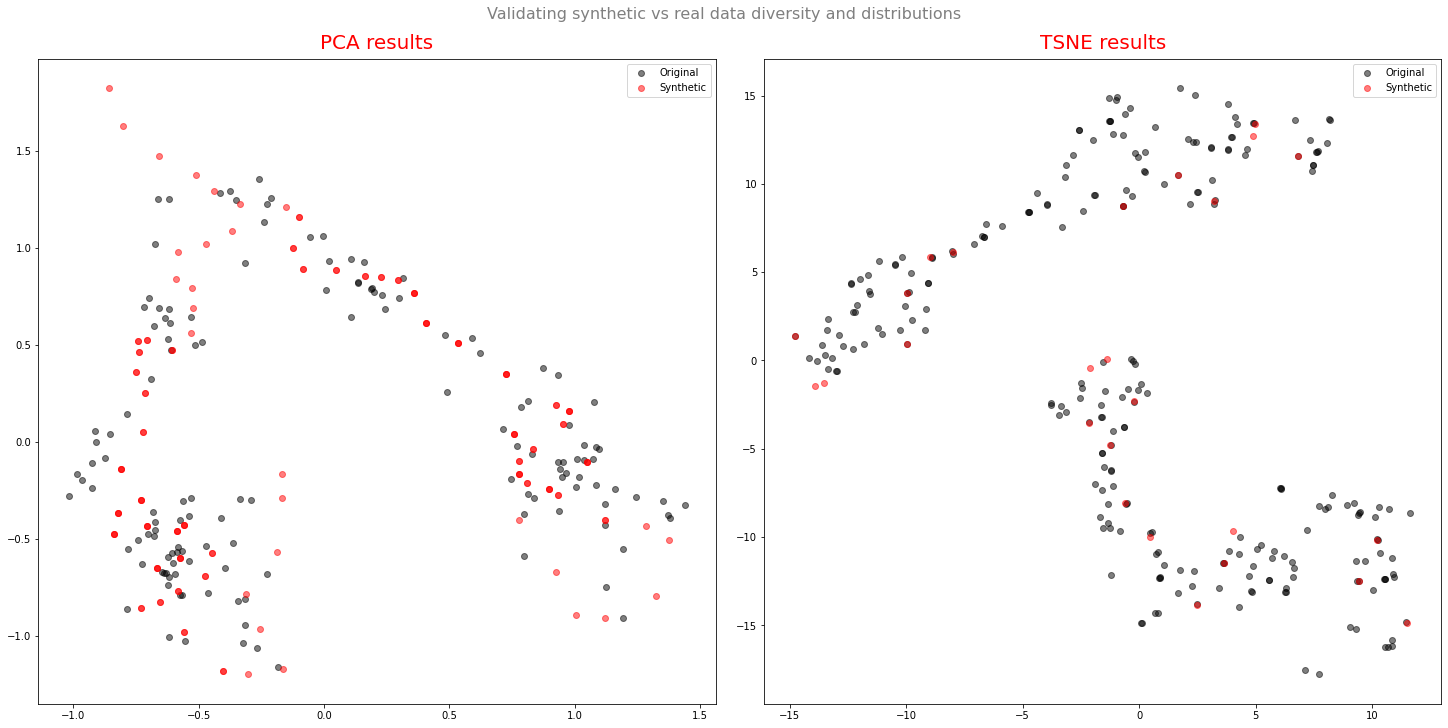

In [ ]:
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.5, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.5, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.5, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.5, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

## 생성된 데이터 및 테스트 데이터 저장

In [ ]:
data_ary = synth.sample(len(stock_data)).reshape(-1,6)
for i in range(14):
  data = synth.sample(len(stock_data)).reshape(-1,6)
  data_ary = np.vstack([data_ary,data])

with open('./data.pkl','wb') as f:
  pickle.dump(data_ary,f)

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


In [ ]:
data_ary_ = synth.sample(len(stock_data))
for i in range(14):
  data = synth.sample(len(stock_data))
  data_ary_ = np.vstack([data_ary_,data])

with open('./data_lstm.pkl','wb') as f:
  pickle.dump(data_ary_,f)

Synthetic data generation: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


In [ ]:
with open('./test_data.pkl','wb') as f:
  pickle.dump(df_test,f)

## MLP 모형으로 뉴스민감도지수 산출

In [ ]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [ ]:
scaler = MinMaxScaler().fit(data_test)
data_test = scaler.transform(data_test)

In [ ]:
d_test = pd.DataFrame(data_test, columns= ['close', 'open', 'high', 'low', 'volume', 'sc'])
d_test

,close,open,high,low,volume,sc
0,0.000000,0.053664,0.000000,0.000000,0.144118,0.332109
1,0.212975,0.000000,0.187785,0.063336,0.226852,0.657640
2,0.202299,0.292306,0.243447,0.248538,0.197111,0.748517
3,0.302427,0.210521,0.281545,0.270120,0.328216,0.000000
4,0.506411,0.405187,0.455685,0.459260,0.244726,0.645105
5,0.528172,0.509055,0.551893,0.560977,0.153543,0.403965
6,0.556148,0.589522,0.545802,0.594003,0.348246,0.523603
7,0.566914,0.631966,0.564764,0.580673,0.286368,0.747437
8,0.577445,0.595870,0.578030,0.627029,0.323813,0.616668
9,0.605488,0.617814,0.586145,0.645108,0.322231,0.499592


In [ ]:
x_test = d_test[['close', 'open', 'high', 'low', 'volume']]
y_test = d_test['sc']

x_test = x_test.to_numpy()
y_test = y_test.to_numpy().reshape(-1,1)

print(x_test.shape, y_test.shape)

(20, 5) (20, 1)


In [ ]:
d = pd.DataFrame(data, columns= ['close', 'open', 'high', 'low', 'volume', 'sc'])
d

,close,open,high,low,volume,sc
0,0.679939,0.754319,0.724754,0.716506,0.123080,0.525281
1,0.670060,0.615876,0.650476,0.669419,0.049128,0.607139
2,0.668532,0.623763,0.633809,0.671634,0.079323,0.727779
3,0.675677,0.641022,0.718297,0.729535,0.114648,0.405816
4,0.744892,0.867653,0.829303,0.821967,0.068457,0.508060
...,...,...,...,...,...,...
40315,0.646178,0.584652,0.699100,0.547962,0.398440,0.460289
40316,0.778827,0.769415,0.814211,0.747437,0.394365,0.003182
40317,0.760396,0.868146,0.836608,0.849889,0.237552,0.296268
40318,0.803939,0.744603,0.755793,0.721910,0.286268,0.652672


In [ ]:
x = d[['close', 'open', 'high', 'low', 'volume']]
y = d['sc']

x = x.to_numpy()
y = y.to_numpy().reshape(-1,1)

x_train, x_val, y_train, y_val = train_test_split(x, y, shuffle=True, test_size = 0.3)

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(28224, 5) (12096, 5)
(28224, 1) (12096, 1)


In [ ]:
def Mbuild():
  model = Sequential()
  input = Input(shape=(5), name='input')
  hidden1 = Dense(128, activation='relu', name='dense1')(input)
  Dropout(0.5)(hidden1)
  hidden2 = Dense(256, activation='relu', name='dense2')(hidden1)
  Dropout(0.5)(hidden2)
  hidden3 = Dense(64, activation='elu', name='dense3')(hidden2)
  output = Dense(1, name='output')(hidden3)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='mse',
                metrics=['mae'])
  return model

In [ ]:
model = Mbuild()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5)]               0         
                                                                 
 dense1 (Dense)              (None, 128)               768       
                                                                 
 dense2 (Dense)              (None, 256)               33024     
                                                                 
 dense3 (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=200,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping, mc])

Epoch 1/200
142/142 [==============================] - 11s 12ms/step - loss: 0.1213 - mae: 0.2788 - val_loss: 0.0695 - val_mae: 0.2176
Epoch 2/200
142/142 [==============================] - 1s 9ms/step - loss: 0.0550 - mae: 0.1920 - val_loss: 0.0489 - val_mae: 0.1810
Epoch 3/200
142/142 [==============================] - 1s 9ms/step - loss: 0.0463 - mae: 0.1744 - val_loss: 0.0469 - val_mae: 0.1752
Epoch 4/200
142/142 [==============================] - 2s 11ms/step - loss: 0.0453 - mae: 0.1714 - val_loss: 0.0464 - val_mae: 0.1719
Epoch 5/200
142/142 [==============================] - 1s 9ms/step - loss: 0.0447 - mae: 0.1695 - val_loss: 0.0457 - val_mae: 0.1722
Epoch 6/200
142/142 [==============================] - 2s 12ms/step - loss: 0.0441 - mae: 0.1680 - val_loss: 0.0450 - val_mae: 0.1691
Epoch 7/200
142/142 [==============================] - 2s 14ms/step - loss: 0.0433 - mae: 0.1662 - val_loss: 0.0442 - val_mae: 0.1678
Epoch 8/200
142/142 [==============================] - 1s 11ms/s

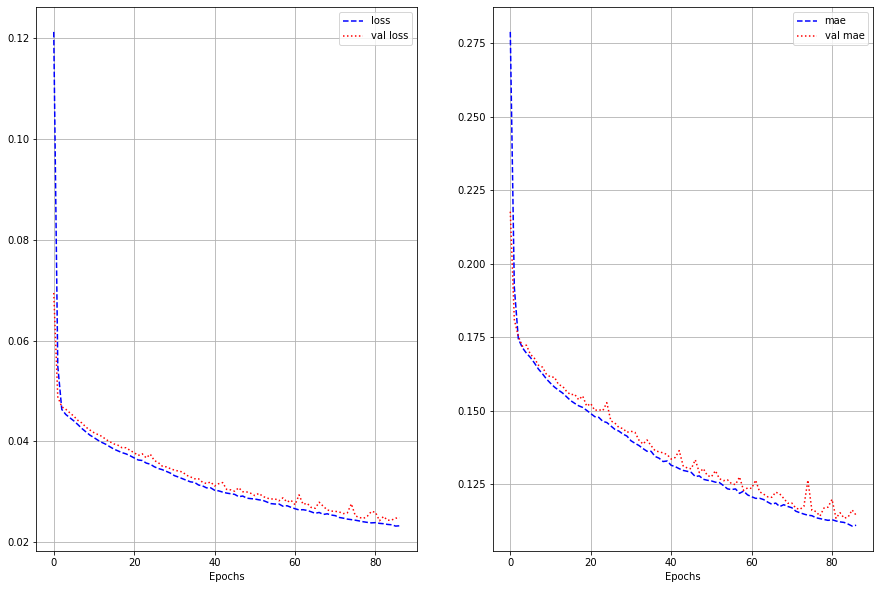

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], 'b--', label='mae')
plt.plot(history.history['val_mae'], 'r:', label='val mae')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

In [ ]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 26ms/step - loss: 0.2417 - mae: 0.3468


[0.24170880019664764, 0.34684261679649353]

4/4 [==============================] - 0s 3ms/step


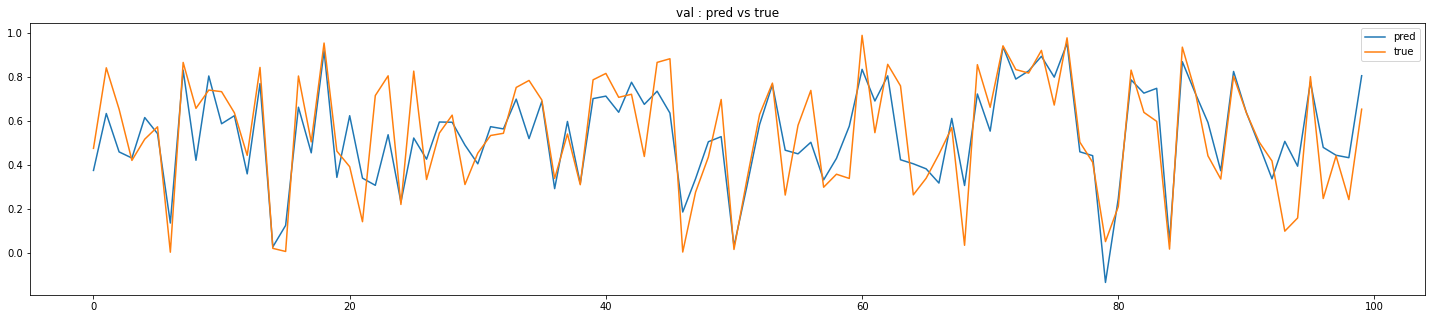

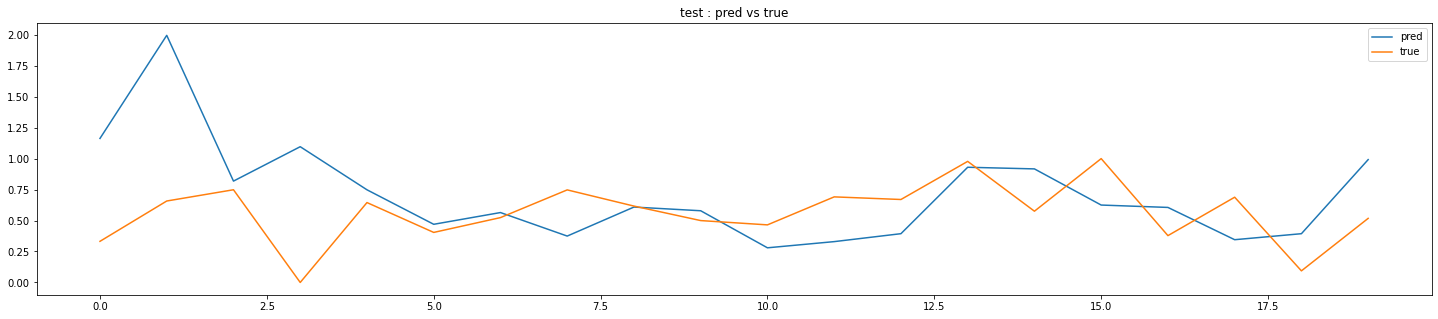

In [ ]:
pred = model.predict(x_test)
pred_val = model.predict(x_val[:100])

plt.figure(figsize=(25,5))
plt.plot(pred_val, label='pred')
plt.plot(y_val[:100], label='true')
plt.title('val : pred vs true')
plt.legend()
plt.show()

plt.figure(figsize=(25,5))
plt.plot(pred, label='pred')
plt.plot(y_test, label='true')
plt.title('test : pred vs true')
plt.legend()
plt.show()

## LSTM 모형으로 뉴스민감도지수 산출

In [ ]:
with open('data_lstm.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('test_data.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [ ]:
scaler = MinMaxScaler().fit(data_test)
data_test = scaler.transform(data_test)

In [ ]:
d_test = pd.DataFrame(data_test, columns= ['close', 'open', 'high', 'low', 'volume', 'sc'])
d_test

,close,open,high,low,volume,sc
0,0.000000,0.053664,0.000000,0.000000,0.144118,0.332109
1,0.212975,0.000000,0.187785,0.063336,0.226852,0.657640
2,0.202299,0.292306,0.243447,0.248538,0.197111,0.748517
3,0.302427,0.210521,0.281545,0.270120,0.328216,0.000000
4,0.506411,0.405187,0.455685,0.459260,0.244726,0.645105
5,0.528172,0.509055,0.551893,0.560977,0.153543,0.403965
6,0.556148,0.589522,0.545802,0.594003,0.348246,0.523603
7,0.566914,0.631966,0.564764,0.580673,0.286368,0.747437
8,0.577445,0.595870,0.578030,0.627029,0.323813,0.616668
9,0.605488,0.617814,0.586145,0.645108,0.322231,0.499592


In [ ]:
x_test = d_test[['close', 'open', 'high', 'low', 'volume']]
y_test = d_test['sc']

x_test = x_test.to_numpy()
y_test = y_test.to_numpy().reshape(-1,1)

print(x_test.shape, y_test.shape)
print(x_test)
print('/////////')
print(y_test)
print(len(x_test))

(20, 5) (20, 1)
[[0.         0.05366448 0.         0.         0.14411832]
 [0.21297534 0.         0.18778492 0.0633364  0.22685164]
 [0.20229928 0.29230621 0.24344713 0.24853849 0.19711075]
 [0.30242715 0.21052093 0.28154457 0.2701197  0.32821601]
 [0.50641089 0.40518716 0.45568531 0.45926038 0.24472598]
 [0.52817173 0.50905537 0.55189318 0.56097682 0.15354277]
 [0.55614786 0.58952226 0.54580152 0.59400278 0.34824582]
 [0.56691442 0.63196627 0.56476362 0.58067256 0.28636781]
 [0.57744452 0.59586982 0.57802959 0.62702874 0.32381335]
 [0.60548779 0.61781353 0.58614507 0.64510836 0.32223114]
 [0.54011771 0.62500781 0.573214   0.57739085 0.14610181]
 [0.49290014 0.55708262 0.50988091 0.52206357 0.11585645]
 [0.55778561 0.48910344 0.50476795 0.5349183  0.07530383]
 [0.63012711 0.59389793 0.57839913 0.6030151  0.        ]
 [0.82692341 0.80346985 0.77776976 0.81718361 0.77925934]
 [0.97070724 0.87419377 0.91684157 0.85407671 0.72383628]
 [1.         1.         1.         1.         0.4011236 

In [ ]:
x_train = train_data[:-768,:,:-1]
y_train = train_data[:-768,-1,-1].reshape(-1,1)

x_val = train_data[-768:,:,:-1]
y_val = train_data[-768:,-1,-1].reshape(-1,1)
print(x_train.shape, y_train.shape)

(1152, 21, 5) (1152, 1)


In [ ]:
def sliding_windows(x_data, y_data,seq_length):
  x = []
  y = []
  for i in range(len(x_data)-seq_length-1):
    x_ = x_data[i:(i+seq_length)]
    y_ = y_data[i+seq_length-1]
    x.append(x_)
    y.append(y_)
  return np.array(x), np.array(y)

x_test, y_test = sliding_windows(x_test, y_test, 2)     # 21 => 5

In [ ]:
print(x_test)
print(y_test)

[[[0.         0.05366448 0.         0.         0.14411832]
  [0.21297534 0.         0.18778492 0.0633364  0.22685164]]

 [[0.21297534 0.         0.18778492 0.0633364  0.22685164]
  [0.20229928 0.29230621 0.24344713 0.24853849 0.19711075]]

 [[0.20229928 0.29230621 0.24344713 0.24853849 0.19711075]
  [0.30242715 0.21052093 0.28154457 0.2701197  0.32821601]]

 [[0.30242715 0.21052093 0.28154457 0.2701197  0.32821601]
  [0.50641089 0.40518716 0.45568531 0.45926038 0.24472598]]

 [[0.50641089 0.40518716 0.45568531 0.45926038 0.24472598]
  [0.52817173 0.50905537 0.55189318 0.56097682 0.15354277]]

 [[0.52817173 0.50905537 0.55189318 0.56097682 0.15354277]
  [0.55614786 0.58952226 0.54580152 0.59400278 0.34824582]]

 [[0.55614786 0.58952226 0.54580152 0.59400278 0.34824582]
  [0.56691442 0.63196627 0.56476362 0.58067256 0.28636781]]

 [[0.56691442 0.63196627 0.56476362 0.58067256 0.28636781]
  [0.57744452 0.59586982 0.57802959 0.62702874 0.32381335]]

 [[0.57744452 0.59586982 0.57802959 0.62

In [ ]:
model = Sequential([ 
                    LSTM(units = 80, return_sequences = True),
                     Dropout(0.5),
                     LSTM(units = 50, return_sequences = False),
                     Dropout(0.3),
                     Dense(50, activation="tanh"),
                     Dense(1)
])

In [ ]:
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.01, decay=1e-03)
model.compile(loss='mse', optimizer=optimizer, metrics='mae', run_eagerly=True) #run_eagerly=True 디버깅모드

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=15)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(x_train,y_train,batch_size=50, validation_data=(x_val, y_val), shuffle=False,epochs=500, callbacks=[checkpoint, earlystopping])

Epoch 1/500
24/24 [==============================] - ETA: 0s - loss: 0.3012 - mae: 0.3880
Epoch 1: val_loss improved from inf to 0.08434, saving model to tmp/ckeckpointer.ckpt
24/24 [==============================] - 3s 87ms/step - loss: 0.3012 - mae: 0.3880 - val_loss: 0.0843 - val_mae: 0.2391
Epoch 2/500
23/24 [===========================>..] - ETA: 0s - loss: 0.0980 - mae: 0.2588
Epoch 2: val_loss did not improve from 0.08434
24/24 [==============================] - 1s 56ms/step - loss: 0.0981 - mae: 0.2590 - val_loss: 0.0852 - val_mae: 0.2351
Epoch 3/500
23/24 [===========================>..] - ETA: 0s - loss: 0.0924 - mae: 0.2502
Epoch 3: val_loss improved from 0.08434 to 0.08094, saving model to tmp/ckeckpointer.ckpt
24/24 [==============================] - 1s 57ms/step - loss: 0.0924 - mae: 0.2503 - val_loss: 0.0809 - val_mae: 0.2284
Epoch 4/500
23/24 [===========================>..] - ETA: 0s - loss: 0.0843 - mae: 0.2387
Epoch 4: val_loss improved from 0.08094 to 0.07681, savin

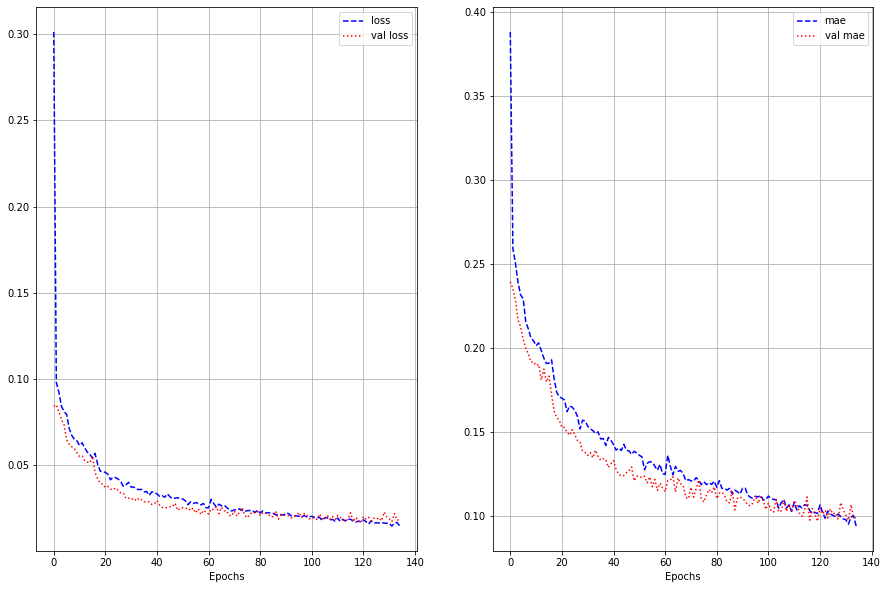

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r:', label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], 'b--', label='mae')
plt.plot(history.history['val_mae'], 'r:', label='val mae')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

In [ ]:
model.evaluate(x_test,y_test)

1/1 [==============================] - 0s 467ms/step - loss: 0.1053 - mae: 0.2616


[0.105308897793293, 0.26162025332450867]

1/1 [==============================] - 0s 32ms/step


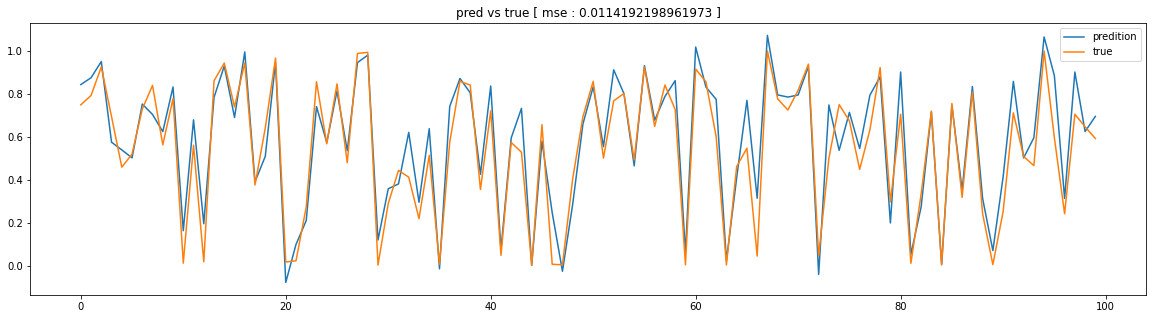

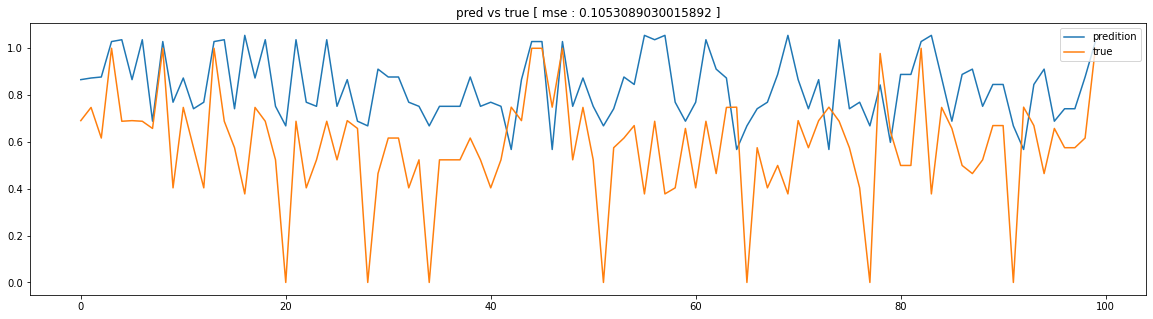

In [ ]:
def pred_vs_true_plot(x_data, y_data):
  outputs = model.predict(x_data)

  idx = np.random.randint(len(outputs), size = 100)
  mse=mean_squared_error(outputs,y_data)
  
  plt.figure(figsize=(20,5))
  plt.title('pred vs true [ mse : %.16f ]'%mse)
  plt.plot(outputs[idx], label='predition')
  plt.plot(y_data[idx], label='true')
  plt.legend(loc='upper right')

pred_vs_true_plot(x_train, y_train)
pred_vs_true_plot(x_test, y_test)

## 최신 뉴스 예측